In [1]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import os
import mne
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix
import tensorflow
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.layers import Dense, Activation, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Flatten, Dropout, BatchNormalization, Input,UpSampling1D
from tensorflow.keras.layers import concatenate, Lambda, Conv2D, MaxPooling2D, GlobalAveragePooling2D,LSTM
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

c:\Users\ryoii\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\ryoii\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
from __00_load_csv import load_alphabet
from __01_transform_data import transform_eeg_data, process_band, MA_X, MA_X2
from __02_model import train, visualize, plot_confusion_matrix, evaluate
from __03_utils import plot_eeg, downsample, plot_eeg_1280
from __04_DomainAdaptation import class_conditional_domain_adaptation

Downsampling EEG Data: 100%|██████████| 220/220 [00:00<00:00, 3826.78it/s]


shape of X_VIE : (220, 2, 1280)
shape of Y_VIE : (220,)


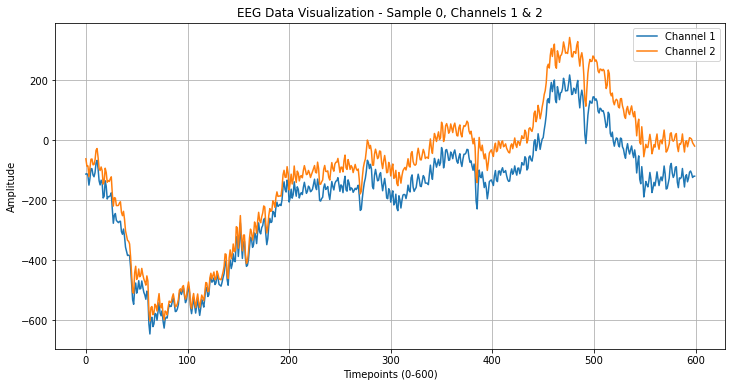

In [3]:
parent_dir = os.path.dirname(os.getcwd())
fo = os.path.join(parent_dir, 'data', 'Vie2Image', 'Char')
os.chdir(parent_dir)

x, Y_VIE = load_alphabet(fo)
X_VIE = downsample(x)

print(f'shape of X_VIE : {X_VIE.shape}')
print(f'shape of Y_VIE : {Y_VIE.shape}')

plot_eeg_1280(X_VIE)

In [5]:
from __00_load_edf import load_alphabet

fo = os.path.join(parent_dir, 'data', 'Envisioned_Speech_Recognition', 'Char')
X_EMOTIV, Y_EMOTIV, channels = load_alphabet(fo)
print(f'shape of X_VIE : {X_EMOTIV.shape}')
print(f'shape of Y_VIE : {Y_EMOTIV.shape}')

Extracting EDF parameters from c:\Users\ryoii\Desktop\EEG2IMAGE\data\Envisioned_Speech_Recognition\Char\aashay_A.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Relevant Channels: ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
Extracting EDF parameters from c:\Users\ryoii\Desktop\EEG2IMAGE\data\Envisioned_Speech_Recognition\Char\aashay_C.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from c:\Users\ryoii\Desktop\EEG2IMAGE\data\Envisioned_Speech_Recognition\Char\aashay_F.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from c:\Users\ryoii\Desktop\EEG2IMAGE\data\Envisioned_Speech_Recognition\Char\aashay_H.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from c:\Users\ryoii\Desktop\EEG2IMAGE\data\Envisioned_

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def plot_combined_correlations(X_VIE, Y_VIE, X_EMOTIV, Y_EMOTIV, vie_labels=['Left', 'Right'], emotiv_labels=['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']):
    """
    Calculate and plot combined correlations between channels in VIE and EMOTIV datasets.

    Parameters:
        X_VIE (numpy.ndarray): EEG data from VIE with shape (instances, channels, data points).
        Y_VIE (numpy.ndarray): Labels for VIE data with shape (instances,).
        X_EMOTIV (numpy.ndarray): EEG data from EMOTIV with shape (instances, channels, data points).
        Y_EMOTIV (numpy.ndarray): Labels for EMOTIV data with shape (instances,).
        vie_labels (list): Labels for VIE channels.
        emotiv_labels (list): Labels for EMOTIV channels.

    Returns:
        None
    """
    n_vie_channels = X_VIE.shape[1]
    n_emotiv_channels = X_EMOTIV.shape[1]
    classes = np.unique(Y_VIE)  # Assuming both datasets share the same class labels

    # Initialize a matrix to store combined correlations
    combined_correlations = np.zeros((n_vie_channels, n_emotiv_channels))

    for cls in classes:
        # Filter data for the current class
        X_VIE_cls = X_VIE[Y_VIE == cls]
        X_EMOTIV_cls = X_EMOTIV[Y_EMOTIV == cls]

        # Align the number of instances
        min_instances = min(X_VIE_cls.shape[0], X_EMOTIV_cls.shape[0])
        X_VIE_cls = X_VIE_cls[:min_instances]
        X_EMOTIV_cls = X_EMOTIV_cls[:min_instances]

        # Calculate correlations for the current class
        for vie_channel in range(n_vie_channels):
            for emotiv_channel in range(n_emotiv_channels):
                vie_data = X_VIE_cls[:, vie_channel, :].reshape(-1)
                emotiv_data = X_EMOTIV_cls[:, emotiv_channel, :].reshape(-1)
                correlation = np.corrcoef(vie_data, emotiv_data)[0, 1]
                combined_correlations[vie_channel, emotiv_channel] += correlation

    # Take the average of the correlations across classes
    combined_correlations /= len(classes)

    # Plot the combined correlations as a bar chart
    fig, ax = plt.subplots(figsize=(12, 6))
    bar_width = 0.35
    index = np.arange(n_emotiv_channels)

    for vie_channel in range(n_vie_channels):
        ax.bar(index + vie_channel * bar_width, combined_correlations[vie_channel], bar_width, label=vie_labels[vie_channel])

    ax.set_xlabel('EMOTIV Channels')
    ax.set_ylabel('Average Correlation Coefficient')
    ax.set_title('Average Correlations Between VIE and EMOTIV Channels')
    ax.set_xticks(index + (bar_width * (n_vie_channels - 1) / 2))
    ax.set_xticklabels(emotiv_labels, rotation=90)
    ax.legend()

    plt.tight_layout()
    plt.show()

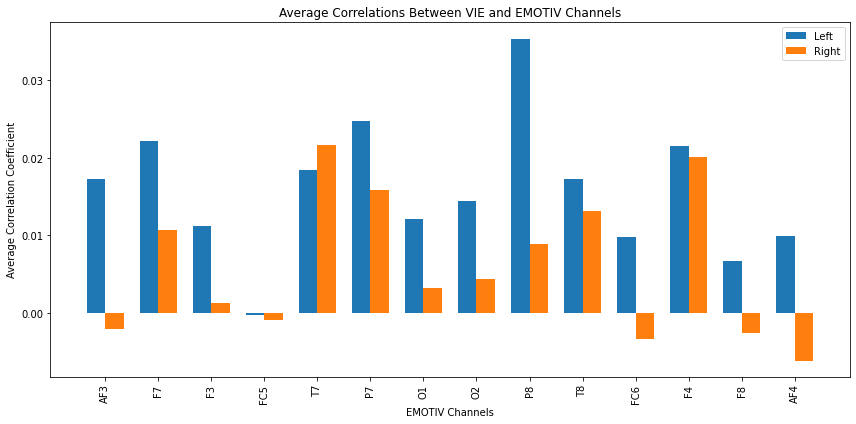

In [22]:
vie_label = ['Left', 'Right']
emotiv_label = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
plot_combined_correlations(X_VIE, Y_VIE, X_EMOTIV, Y_EMOTIV, vie_label, emotiv_label)